# Scratch Assay (Wound Healing) Analysis in Python  
*A Practical Image Segmentation and Quantification Tutorial for Microscopy*

---

## Introduction

In this notebook, we dive into **scratch assay analysis**, also known as **wound healing analysis**. This is one of the **most common assays in life sciences**, and it provides an excellent real-world example of how **classical image processing techniques** (not machine learning) can solve meaningful biological problems efficiently.

Even if you are **not a biologist**, this notebook is valuable because it demonstrates:
- *Texture-based* segmentation
- Automated batch processing
- Quantitative analysis
- End-to-end scientific workflows using Python

---

## What Is a Scratch Assay?

A **scratch assay** is an experiment used to study **cell migration and proliferation**.

### Experimental Overview

1. A **monolayer of cells** is grown on a glass slide.
2. A **scratch (wound)** is manually created, removing cells from a central region.
3. Images are acquired at regular time intervals (e.g., every hour).
4. Over time, cells migrate and proliferate, gradually **closing the wound**.

### The Imaging Goal

The core imaging task is to:
- **Segment the wound region**
- **Measure the wound area**
- **Track how that area decreases over time**
- **Estimate the healing rate**

Ultimately, researchers want a plot of **wound area vs. time**, along with:
- Healing rate (slope)
- Intercept
- R-squared value

---

## The Image Processing Challenge

Here is the key difficulty:

> **Intensity-based (histogram) thresholding does not work.**

Why?
- The scratch region and cell-covered regions often have **similar pixel intensities**
- Simple grayscale segmentation fails

### Solution: Texture-Based Segmentation

We use **entropy filtering**.

---

## Why Entropy?

From basic physics:
- **Entropy measures disorder**

In scratch assay images:
- Clean wound region → **low entropy**
- Cell-rich region → **high entropy**

This makes entropy an excellent discriminator between:
- The scratch (wound)
- The surrounding cells

---

## Required Libraries

In [2]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage import io
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
import numpy as np

We will also later use:

In [2]:
import glob
from scipy import stats

### Step 1: Read the Image

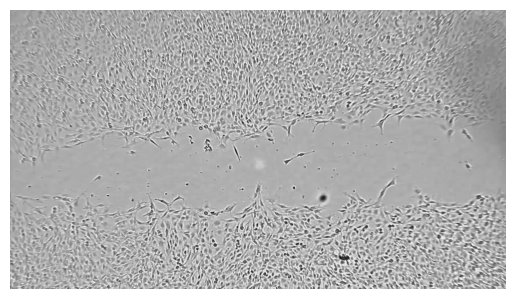

In [3]:
img = io.imread("scratch1.jpg", as_gray=True)

plt.imshow(img, cmap = "gray")
plt.axis("off")
plt.show()

This loads the microscopy image as a **NumPy array**.

### Step 2: Apply Entropy Filtering

In [24]:
entropy_image = entropy(img, disk(10))

print(f"Shape: {entropy_image.shape}")
print(f"Minimum pixel value: {entropy_image.min()}")
print(f"Maximum pixel value: {entropy_image.max()}")
print(f"Type: {entropy_image.dtype}")

c:\Users\Excalibo\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\interactiveshell.py:3577: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


Shape: (720, 1280)
Minimum pixel value: 0.21688022085983039
Maximum pixel value: 7.323823356628502
Type: float64


- `disk(10)` defines the local neighborhood size
- Larger disks smooth texture over larger regions.

However, ther meaybe a warning in the “output” for the first run. If you faced such warning, it is not an error and not an image — it’s a warning message from skimage, telling us that something was automatically converted and might lose precision.   

**What’s happening?**   

we ran:   
`entropy_image = entropy(img, disk(10))`   

But:
- `entropy()` is a rank filter
- Rank filters require `uint8` images
- Our img is `float64`

So scikit-image silently converts our image from float64 to uint8, and warns us:   

“Possible precision loss converting image of type float64 to uint8”

#### Visual Check

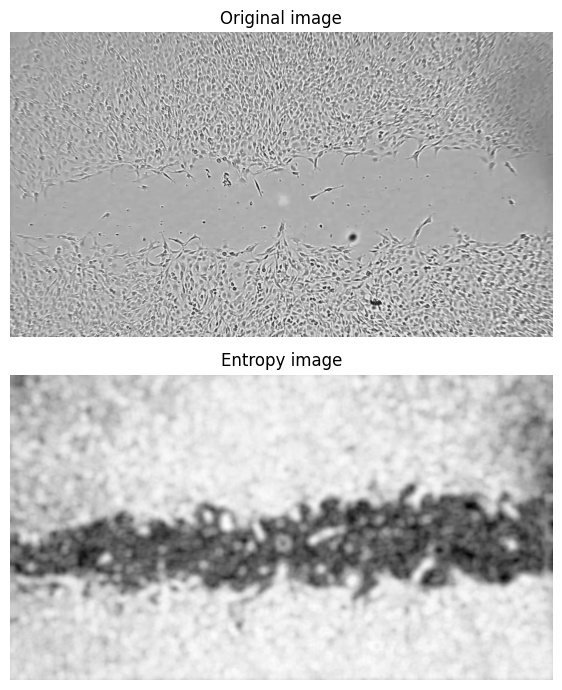

In [18]:
plt.figure(figsize=(6, 7))

plt.subplot(2, 1, 1)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("Original image")

plt.subplot(2, 1, 2)
plt.imshow(entropy_image, cmap="gray")
plt.axis("off")
plt.title("Entropy image")


plt.tight_layout()
plt.show()


Now we see:
- Dark region → scratch
- Bright regions → cells

### Step 3: Automatic Thresholding (Otsu)

We now segment the entropy image using Otsu’s method.

In [19]:
threshold = threshold_otsu(entropy_image)
print(threshold)

4.700361925651395


This returns a single scalar value, not an image.

### Step 4: Create a Binary Segmentation

In [9]:
binary = entropy_image <= threshold

`True` → scratch region   
`False` → cell-covered region

#### Visualize the Result

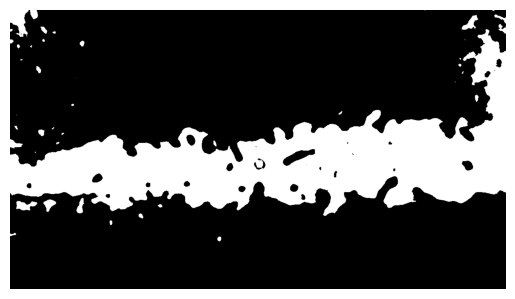

In [10]:
plt.imshow(binary, cmap="gray")
plt.axis("off")
plt.show()

At this point, segmentation is complete!!!

### Step 5: Quantify Wound Area (Single Image)

The binary image is a NumPy array, so quantification is trivial.

In [16]:
scratch_area = np.sum(binary == True)
all = scratch_area + np.sum(binary == False)
print(f"Scratch area: {scratch_area}")
print(f"All area: {all}")
print(f"Surface percentage: {(scratch_area / all) * 100}")

Scratch area: 218875
All area: 921600
Surface percentage: 23.74945746527778


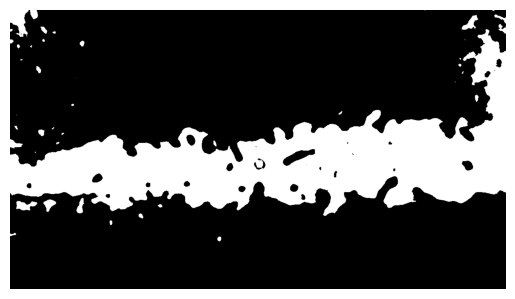

In [17]:
plt.imshow(binary, cmap="gray")
plt.axis("off")
plt.show()

This means that the sratch area covers 23.7 percent of the slide. 